## Cell 1: Import Libraries

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
import pickle
from datetime import datetime

# Sklearn imports
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV,
    cross_val_score, StratifiedKFold, learning_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost available")
except ImportError:
    print("⚠️ XGBoost not installed. Run: pip install xgboost")
    XGBOOST_AVAILABLE = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("✅ All libraries imported successfully!")

✅ XGBoost available
✅ All libraries imported successfully!


## 2. Load Dataset

In [2]:
# Load the training dataset
df = pd.read_csv('data/final/enviroscan_training_set.csv')

print(f"✅ Dataset loaded: {len(df):,} records")
print(f"   Columns: {len(df.columns)}")
print(f"   Unique locations: {df['location_id'].nunique()}")
print(f"   Unique states: {df['state'].nunique()}")

# Display first few rows
df.head()

✅ Dataset loaded: 46,319 records
   Columns: 33
   Unique locations: 47
   Unique states: 18


,state,district,location_id,location_name,latitude,longitude,datetime_ist,hour,day_of_week,month,...,roads_count,industrial_distance_m,industrial_area_sqm,agricultural_distance_m,agricultural_area_sqm,dump_sites_distance_m,dump_sites_count,pollution_source,source_encoded,confidence
0,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 17:30:00+05:30,17,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Vehicular,0,Medium
1,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 17:45:00+05:30,17,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Vehicular,0,Medium
2,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 19:30:00+05:30,19,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Burning,3,Medium
3,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 20:45:00+05:30,20,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Burning,3,Medium
4,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 21:00:00+05:30,21,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Burning,3,High


## 3. Explore Target Variable

📊 Pollution Source Distribution:
   Vehicular      : 17,231 ( 37.2%)
   Agricultural   : 10,740 ( 23.2%)
   Industrial     : 10,352 ( 22.3%)
   Natural        :  5,544 ( 12.0%)
   Burning        :  2,452 (  5.3%)


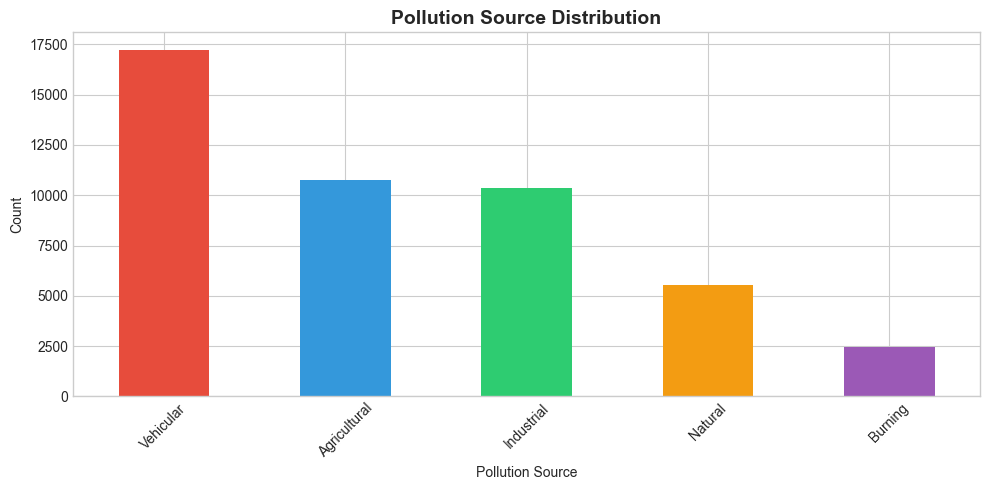

In [3]:
# Target distribution
print("📊 Pollution Source Distribution:")
print("="*50)
target_dist = df['pollution_source'].value_counts()
for source, count in target_dist.items():
    pct = count / len(df) * 100
    print(f"   {source:15}: {count:>6,} ({pct:>5.1f}%)")

# Visualize
plt.figure(figsize=(10, 5))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
target_dist.plot(kind='bar', color=colors[:len(target_dist)])
plt.title('Pollution Source Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Pollution Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Feature Selection

Select features based on:
- Pollutant concentrations
- Weather parameters
- Proximity/spatial features

In [4]:
# Define feature groups
pollutant_features = ['pm25', 'pm10', 'no2', 'co', 'so2', 'o3']
weather_features = ['temperature', 'humidity', 'wind_speed']
proximity_features = ['dist_to_road', 'dist_to_industrial', 'dist_to_agricultural', 'dist_to_dump']

# Combine all features
all_features = pollutant_features + weather_features + proximity_features

# Check which features exist in dataset
available_features = [f for f in all_features if f in df.columns]
missing_features = [f for f in all_features if f not in df.columns]

print("📊 Feature Selection:")
print("="*50)
print(f"\n✅ Available features ({len(available_features)}):")
for f in available_features:
    print(f"   - {f}")

if missing_features:
    print(f"\n⚠️ Missing features ({len(missing_features)}):")
    for f in missing_features:
        print(f"   - {f}")

# Use available features
feature_cols = available_features
print(f"\n📌 Using {len(feature_cols)} features for training")

📊 Feature Selection:

✅ Available features (9):
   - pm25
   - pm10
   - no2
   - co
   - so2
   - o3
   - temperature
   - humidity
   - wind_speed

⚠️ Missing features (4):
   - dist_to_road
   - dist_to_industrial
   - dist_to_agricultural
   - dist_to_dump

📌 Using 9 features for training


## 5. Data Preprocessing

In [5]:
# Check for missing values in features
print("📊 Missing Values in Features:")
missing_info = df[feature_cols].isnull().sum()
for feat, missing in missing_info.items():
    if missing > 0:
        print(f"   {feat}: {missing} ({missing/len(df)*100:.2f}%)")

# Fill missing values with median
df_clean = df.copy()
for col in feature_cols:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)

print(f"\n✅ Missing values filled with median")
print(f"   Total records: {len(df_clean):,}")

📊 Missing Values in Features:

✅ Missing values filled with median
   Total records: 46,319


## 6. Prepare Features and Target

In [6]:
# Prepare X (features) and y (target)
X = df_clean[feature_cols].values
y_raw = df_clean['pollution_source'].values

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

class_names = label_encoder.classes_
n_classes = len(class_names)

print("📊 Data Prepared:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   Classes ({n_classes}): {list(class_names)}")

📊 Data Prepared:
   X shape: (46319, 9)
   y shape: (46319,)
   Classes (5): ['Agricultural', 'Burning', 'Industrial', 'Natural', 'Vehicular']


## 7. Train-Test Split (80/20)

In [7]:
# Stratified train-test split (maintains class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20,
    random_state=42,
    stratify=y  # Maintain class distribution
)

print("📊 Train-Test Split (80/20):")
print(f"   Training set: {len(X_train):,} samples")
print(f"   Test set:     {len(X_test):,} samples")

# Verify class distribution
print("\n📊 Class Distribution:")
for i, cls in enumerate(class_names):
    train_pct = (y_train == i).sum() / len(y_train) * 100
    test_pct = (y_test == i).sum() / len(y_test) * 100
    print(f"   {cls:15}: Train={train_pct:.1f}% | Test={test_pct:.1f}%")

📊 Train-Test Split (80/20):
   Training set: 37,055 samples
   Test set:     9,264 samples

📊 Class Distribution:
   Agricultural   : Train=23.2% | Test=23.2%
   Burning        : Train=5.3% | Test=5.3%
   Industrial     : Train=22.3% | Test=22.4%
   Natural        : Train=12.0% | Test=12.0%
   Vehicular      : Train=37.2% | Test=37.2%


## 8. Feature Scaling

In [8]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")
print(f"   Train mean: {X_train_scaled.mean():.6f}")
print(f"   Train std:  {X_train_scaled.std():.6f}")

✅ Features scaled using StandardScaler
   Train mean: -0.000000
   Train std:  1.000000


## 9. Helper Functions for Model Evaluation

In [9]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Comprehensive model evaluation"""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, average='weighted'),
        'Recall': recall_score(y_test, y_test_pred, average='weighted'),
        'F1_Score': f1_score(y_test, y_test_pred, average='weighted')
    }
    
    # Overfitting indicator
    metrics['Overfit_Gap'] = metrics['Train_Accuracy'] - metrics['Test_Accuracy']
    
    return metrics, y_test_pred


def plot_confusion_matrix(y_true, y_pred, class_names, model_name, save_path=None):
    """Plot and optionally save confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_learning_curve(model, X, y, model_name, cv=5):
    """Plot learning curve to detect overfitting/underfitting"""
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Cross-Validation Score')
    
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f'Learning Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Diagnose overfitting/underfitting
    final_gap = train_mean[-1] - test_mean[-1]
    final_cv = test_mean[-1]
    
    if final_gap > 0.15:
        print(f"   ⚠️ HIGH OVERFITTING (gap: {final_gap:.3f})")
    elif final_gap > 0.05:
        print(f"   ⚠️ Moderate overfitting (gap: {final_gap:.3f})")
    elif final_cv < 0.5:
        print(f"   ⚠️ UNDERFITTING (CV score: {final_cv:.3f})")
    else:
        print(f"   ✅ Good generalization (gap: {final_gap:.3f}, CV: {final_cv:.3f})")
    
    return final_gap, final_cv


def print_metrics(metrics):
    """Pretty print model metrics"""
    print(f"\n📊 {metrics['Model']} Results:")
    print("="*50)
    print(f"   Train Accuracy:  {metrics['Train_Accuracy']:.4f} ({metrics['Train_Accuracy']*100:.2f}%)")
    print(f"   Test Accuracy:   {metrics['Test_Accuracy']:.4f} ({metrics['Test_Accuracy']*100:.2f}%)")
    print(f"   Precision:       {metrics['Precision']:.4f}")
    print(f"   Recall:          {metrics['Recall']:.4f}")
    print(f"   F1-Score:        {metrics['F1_Score']:.4f}")
    print(f"   Overfit Gap:     {metrics['Overfit_Gap']:.4f}")
    
    if metrics['Overfit_Gap'] > 0.15:
        print("   ⚠️ Warning: High overfitting detected!")
    elif metrics['Overfit_Gap'] < 0.05:
        print("   ✅ Good generalization!")

print("✅ Helper functions defined!")

✅ Helper functions defined!


---
# 🌳 Model 1: Decision Tree Classifier
---

## 10. Train Decision Tree with Hyperparameter Tuning

In [10]:
print("🌳 Training Decision Tree Classifier...")
print("="*50)

# Define parameter grid for GridSearchCV
dt_param_grid = {
    'max_depth': [5, 8, 10, 12, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Create base model
dt_base = DecisionTreeClassifier(random_state=42)

# GridSearchCV with 5-fold cross-validation
dt_grid = GridSearchCV(
    dt_base,
    dt_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit the model
dt_grid.fit(X_train_scaled, y_train)

print(f"\n✅ Best Parameters: {dt_grid.best_params_}")
print(f"✅ Best CV Score: {dt_grid.best_score_:.4f}")

# Get best model
dt_best = dt_grid.best_estimator_

🌳 Training Decision Tree Classifier...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

✅ Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
✅ Best CV Score: 0.9607


## 11. Evaluate Decision Tree


📊 Decision Tree Results:
   Train Accuracy:  0.9996 (99.96%)
   Test Accuracy:   0.9652 (96.52%)
   Precision:       0.9652
   Recall:          0.9652
   F1-Score:        0.9652
   Overfit Gap:     0.0344
   ✅ Good generalization!

📋 Classification Report:
              precision    recall  f1-score   support

Agricultural       0.97      0.97      0.97      2148
     Burning       0.97      0.97      0.97       490
  Industrial       0.96      0.96      0.96      2071
     Natural       0.97      0.97      0.97      1109
   Vehicular       0.97      0.97      0.97      3446

    accuracy                           0.97      9264
   macro avg       0.97      0.97      0.97      9264
weighted avg       0.97      0.97      0.97      9264



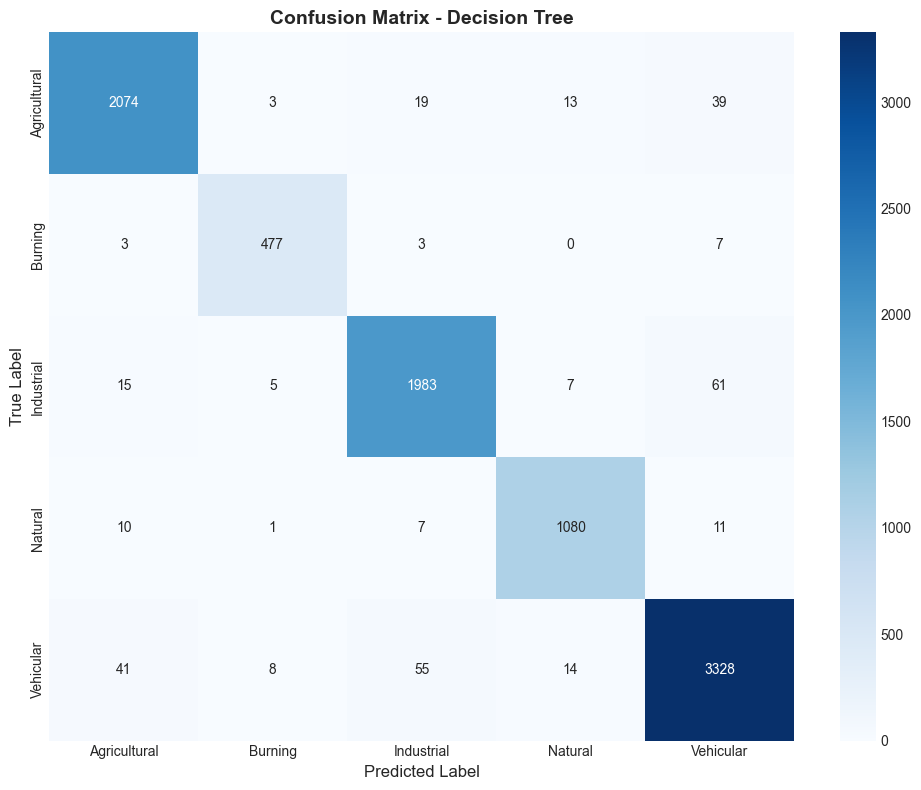

In [11]:
# Evaluate model
dt_metrics, dt_pred = evaluate_model(
    dt_best, X_train_scaled, X_test_scaled,
    y_train, y_test, 'Decision Tree'
)

print_metrics(dt_metrics)

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, dt_pred, target_names=class_names))

# Confusion Matrix
os.makedirs('data/final', exist_ok=True)
plot_confusion_matrix(y_test, dt_pred, class_names, 'Decision Tree', 
                      'data/final/confusion_matrix_decision_tree.png')

## 12. Decision Tree Learning Curve

📈 Decision Tree Learning Curve:
   ✅ Good generalization (gap: 0.039, CV: 0.961)


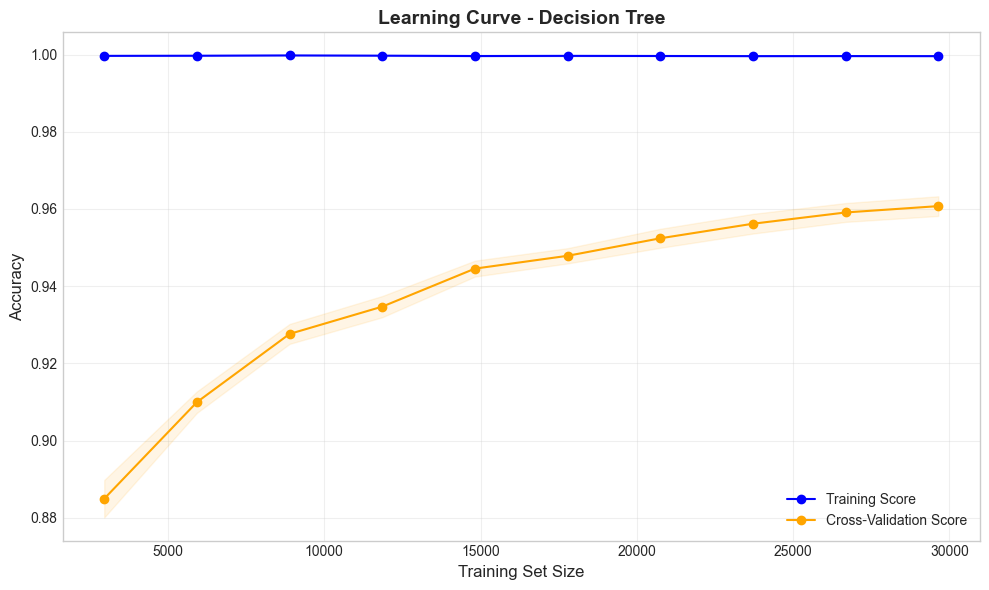

In [12]:
print("📈 Decision Tree Learning Curve:")
dt_gap, dt_cv = plot_learning_curve(dt_best, X_train_scaled, y_train, 'Decision Tree')
plt.savefig('data/final/learning_curve_decision_tree.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 🌲 Model 2: Random Forest Classifier
---

## 13. Train Random Forest with Hyperparameter Tuning

In [13]:
print("🌲 Training Random Forest Classifier...")
print("="*50)

# OPTIMIZED: Reduced search space for faster training
rf_param_dist = {
    'n_estimators': [50, 100, 150],      # Reduced from 5 to 3 options
    'max_depth': [10, 15, 20],            # Removed None (unlimited depth causes slowness)
    'min_samples_split': [5, 10],         # Reduced options
    'min_samples_leaf': [2, 4],           # Reduced options
    'max_features': ['sqrt', 'log2']      # Removed None
}

# Create base model with warm_start for faster fitting
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1, warm_start=False)

# RandomizedSearchCV - REDUCED iterations and CV folds for speed
rf_search = RandomizedSearchCV(
    rf_base,
    rf_param_dist,
    n_iter=15,        # Reduced from 30 to 15
    cv=3,             # Reduced from 5 to 3 folds
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,        # Increased verbosity for progress
    random_state=42
)

print("⏳ Starting hyperparameter search (15 iterations, 3-fold CV)...")
print("   This should take 2-5 minutes...")

# Fit the model
rf_search.fit(X_train_scaled, y_train)

print(f"\n✅ Best Parameters: {rf_search.best_params_}")
print(f"✅ Best CV Score: {rf_search.best_score_:.4f}")

# Get best model
rf_best = rf_search.best_estimator_

🌲 Training Random Forest Classifier...
⏳ Starting hyperparameter search (15 iterations, 3-fold CV)...
   This should take 2-5 minutes...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

✅ Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}
✅ Best CV Score: 0.9826


## 14. Evaluate Random Forest


📊 Random Forest Results:
   Train Accuracy:  0.9985 (99.85%)
   Test Accuracy:   0.9865 (98.65%)
   Precision:       0.9866
   Recall:          0.9865
   F1-Score:        0.9865
   Overfit Gap:     0.0120
   ✅ Good generalization!

📋 Classification Report:
              precision    recall  f1-score   support

Agricultural       0.99      0.98      0.99      2148
     Burning       0.99      1.00      0.99       490
  Industrial       0.99      0.98      0.98      2071
     Natural       0.99      0.99      0.99      1109
   Vehicular       0.98      0.99      0.99      3446

    accuracy                           0.99      9264
   macro avg       0.99      0.99      0.99      9264
weighted avg       0.99      0.99      0.99      9264



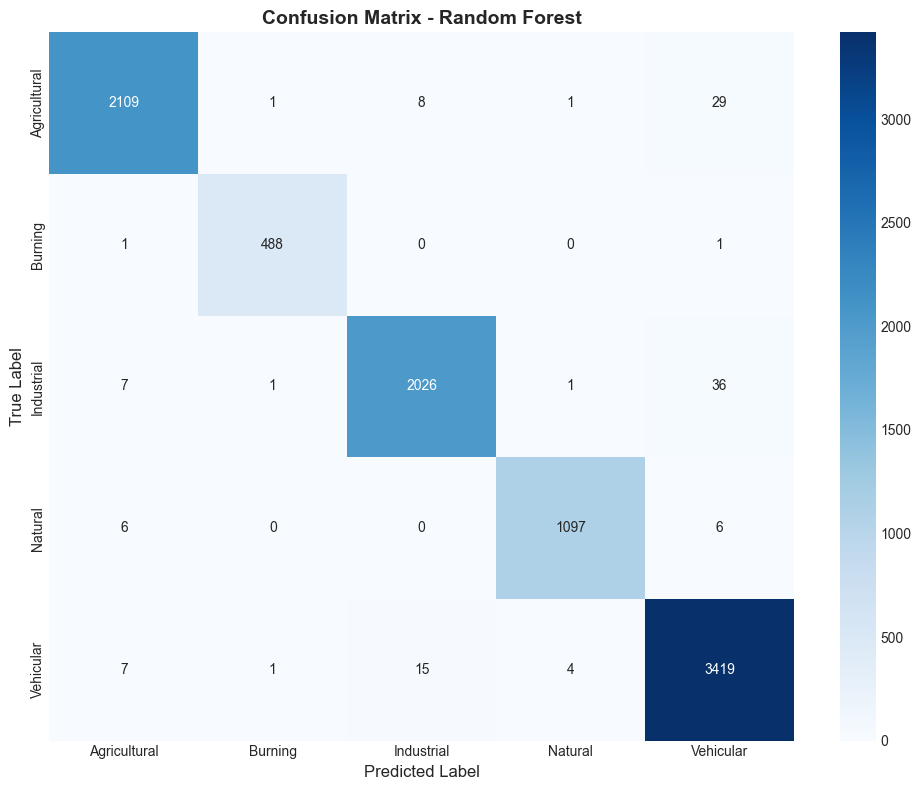

In [14]:
# Evaluate model
rf_metrics, rf_pred = evaluate_model(
    rf_best, X_train_scaled, X_test_scaled,
    y_train, y_test, 'Random Forest'
)

print_metrics(rf_metrics)

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, rf_pred, target_names=class_names))

# Confusion Matrix
plot_confusion_matrix(y_test, rf_pred, class_names, 'Random Forest',
                      'data/final/confusion_matrix_random_forest.png')

## 15. Random Forest Learning Curve

📈 Random Forest Learning Curve:
   ✅ Good generalization (gap: 0.014, CV: 0.984)


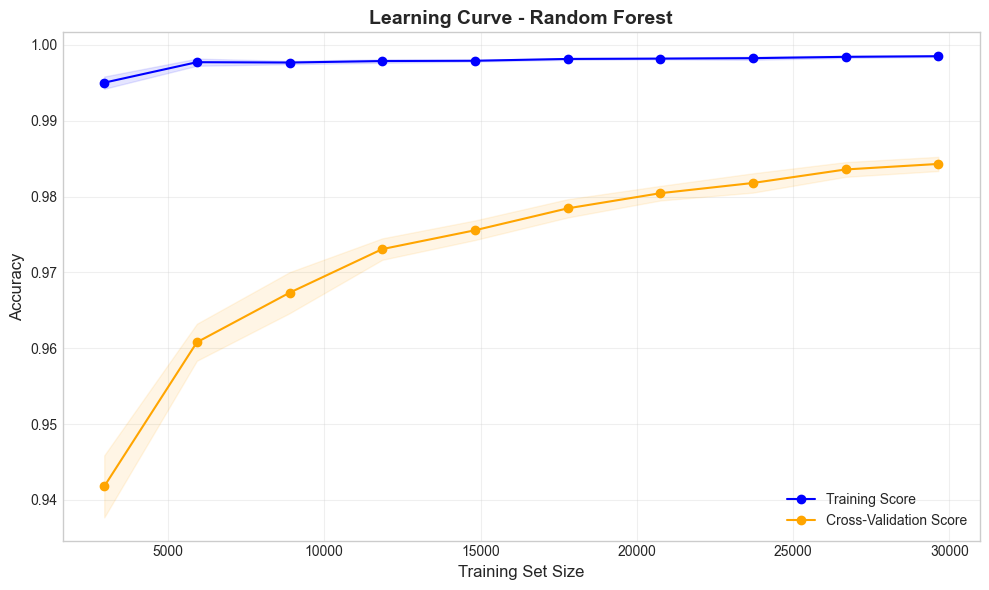

In [15]:
print("📈 Random Forest Learning Curve:")
rf_gap, rf_cv = plot_learning_curve(rf_best, X_train_scaled, y_train, 'Random Forest')
plt.savefig('data/final/learning_curve_random_forest.png', dpi=150, bbox_inches='tight')
plt.show()

## 16. Random Forest Feature Importance

📊 Feature Importance (Random Forest):
   no2                 : 0.1945
   so2                 : 0.1557
   co                  : 0.1405
   wind_speed          : 0.1216
   o3                  : 0.1052
   humidity            : 0.0850
   pm10                : 0.0762
   pm25                : 0.0721
   temperature         : 0.0491


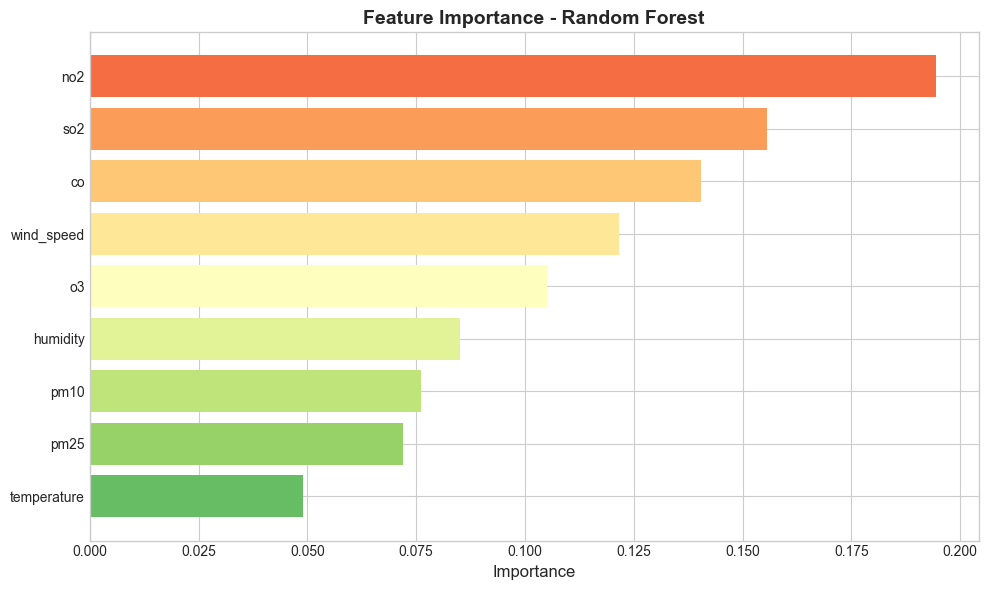

In [16]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("📊 Feature Importance (Random Forest):")
print("="*50)
for _, row in feature_importance.iterrows():
    print(f"   {row['Feature']:20}: {row['Importance']:.4f}")

# Plot
plt.figure(figsize=(10, 6))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(feature_importance)))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('data/final/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 🚀 Model 3: XGBoost Classifier
---

## 17. Train XGBoost with Hyperparameter Tuning

In [17]:
if XGBOOST_AVAILABLE:
    print("🚀 Training XGBoost Classifier...")
    print("="*50)
    
    # Simplified parameter grid for faster training
    xgb_param_dist = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
    
    # Create base model - NO parallel processing to avoid memory issues
    xgb_base = XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_jobs=1,  # Single thread to avoid memory crash
        verbosity=0
    )
    
    # RandomizedSearchCV - NO parallel processing
    xgb_search = RandomizedSearchCV(
        xgb_base,
        xgb_param_dist,
        n_iter=10,        # Reduced iterations
        cv=3,             # 3-fold CV
        scoring='f1_weighted',
        n_jobs=1,         # Single thread to avoid TerminatedWorkerError
        verbose=2,
        random_state=42
    )
    
    print("⏳ Starting hyperparameter search (10 iterations, 3-fold CV)...")
    print("   This should take 2-5 minutes...")
    
    # Fit the model
    xgb_search.fit(X_train_scaled, y_train)
    
    print(f"\n✅ Best Parameters: {xgb_search.best_params_}")
    print(f"✅ Best CV Score: {xgb_search.best_score_:.4f}")
    
    # Get best model
    xgb_best = xgb_search.best_estimator_
else:
    print("⚠️ XGBoost not available. Skipping...")

🚀 Training XGBoost Classifier...
⏳ Starting hyperparameter search (10 iterations, 3-fold CV)...
   This should take 2-5 minutes...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=150, subsample=0.7; total time=   4.7s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=150, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=150, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.9; total time=   2.

## 18. Evaluate XGBoost


📊 XGBoost Results:
   Train Accuracy:  0.9996 (99.96%)
   Test Accuracy:   0.9915 (99.15%)
   Precision:       0.9915
   Recall:          0.9915
   F1-Score:        0.9915
   Overfit Gap:     0.0081
   ✅ Good generalization!

📋 Classification Report:
              precision    recall  f1-score   support

Agricultural       0.99      0.99      0.99      2148
     Burning       1.00      1.00      1.00       490
  Industrial       0.99      0.99      0.99      2071
     Natural       1.00      0.99      1.00      1109
   Vehicular       0.99      0.99      0.99      3446

    accuracy                           0.99      9264
   macro avg       0.99      0.99      0.99      9264
weighted avg       0.99      0.99      0.99      9264



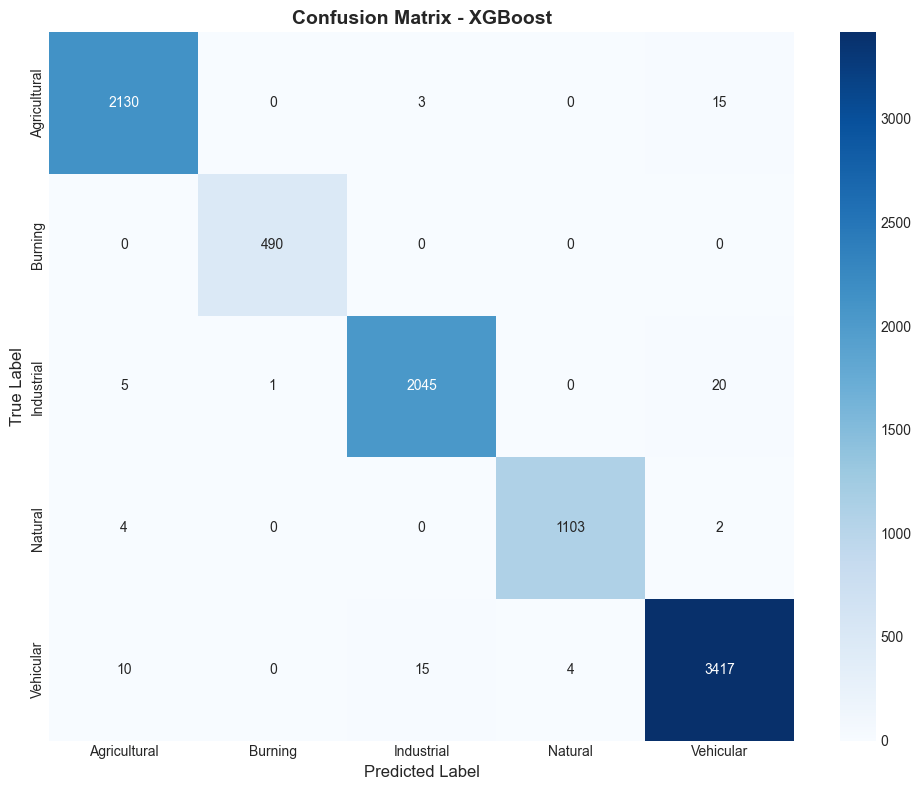

In [18]:
if XGBOOST_AVAILABLE:
    # Evaluate model
    xgb_metrics, xgb_pred = evaluate_model(
        xgb_best, X_train_scaled, X_test_scaled,
        y_train, y_test, 'XGBoost'
    )
    
    print_metrics(xgb_metrics)
    
    # Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(y_test, xgb_pred, target_names=class_names))
    
    # Confusion Matrix
    plot_confusion_matrix(y_test, xgb_pred, class_names, 'XGBoost',
                          'data/final/confusion_matrix_xgboost.png')
else:
    print("⚠️ XGBoost not available")

## 19. XGBoost Learning Curve

📈 XGBoost Learning Curve:
   ✅ Good generalization (gap: 0.009, CV: 0.990)


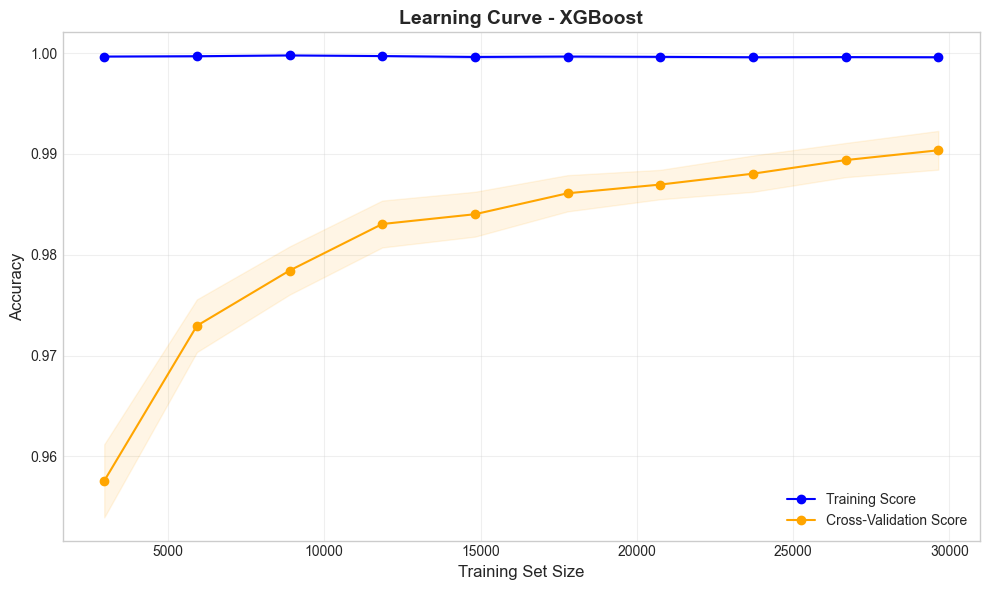

In [19]:
if XGBOOST_AVAILABLE:
    print("📈 XGBoost Learning Curve:")
    xgb_gap, xgb_cv = plot_learning_curve(xgb_best, X_train_scaled, y_train, 'XGBoost')
    plt.savefig('data/final/learning_curve_xgboost.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ XGBoost not available")

---
# 📊 Model Comparison & Selection
---

## 20. Compare All Models

In [20]:
# Collect all metrics
all_metrics = [dt_metrics, rf_metrics]
if XGBOOST_AVAILABLE:
    all_metrics.append(xgb_metrics)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_metrics)
comparison_df = comparison_df.set_index('Model')

print("="*70)
print("📊 MODEL COMPARISON SUMMARY")
print("="*70)
print(comparison_df.round(4).to_string())

# Overfitting analysis
print("\n📊 Overfitting Analysis:")
print("-"*50)
for model_name in comparison_df.index:
    gap = comparison_df.loc[model_name, 'Overfit_Gap']
    if gap > 0.15:
        status = "❌ HIGH OVERFITTING"
    elif gap > 0.05:
        status = "⚠️ Moderate"
    else:
        status = "✅ Good"
    print(f"   {model_name:15}: Gap={gap:.4f} {status}")

# Best model selection
best_idx = comparison_df['Test_Accuracy'].idxmax()
print(f"\n🏆 BEST MODEL: {best_idx}")
print(f"   Test Accuracy: {comparison_df.loc[best_idx, 'Test_Accuracy']:.4f}")
print(f"   F1-Score: {comparison_df.loc[best_idx, 'F1_Score']:.4f}")

📊 MODEL COMPARISON SUMMARY
               Train_Accuracy  Test_Accuracy  Precision  Recall  F1_Score  Overfit_Gap
Model                                                                                 
Decision Tree          0.9996         0.9652     0.9652  0.9652    0.9652       0.0344
Random Forest          0.9985         0.9865     0.9866  0.9865    0.9865       0.0120
XGBoost                0.9996         0.9915     0.9915  0.9915    0.9915       0.0081

📊 Overfitting Analysis:
--------------------------------------------------
   Decision Tree  : Gap=0.0344 ✅ Good
   Random Forest  : Gap=0.0120 ✅ Good
   XGBoost        : Gap=0.0081 ✅ Good

🏆 BEST MODEL: XGBoost
   Test Accuracy: 0.9915
   F1-Score: 0.9915


## 21. Visualize Model Comparison

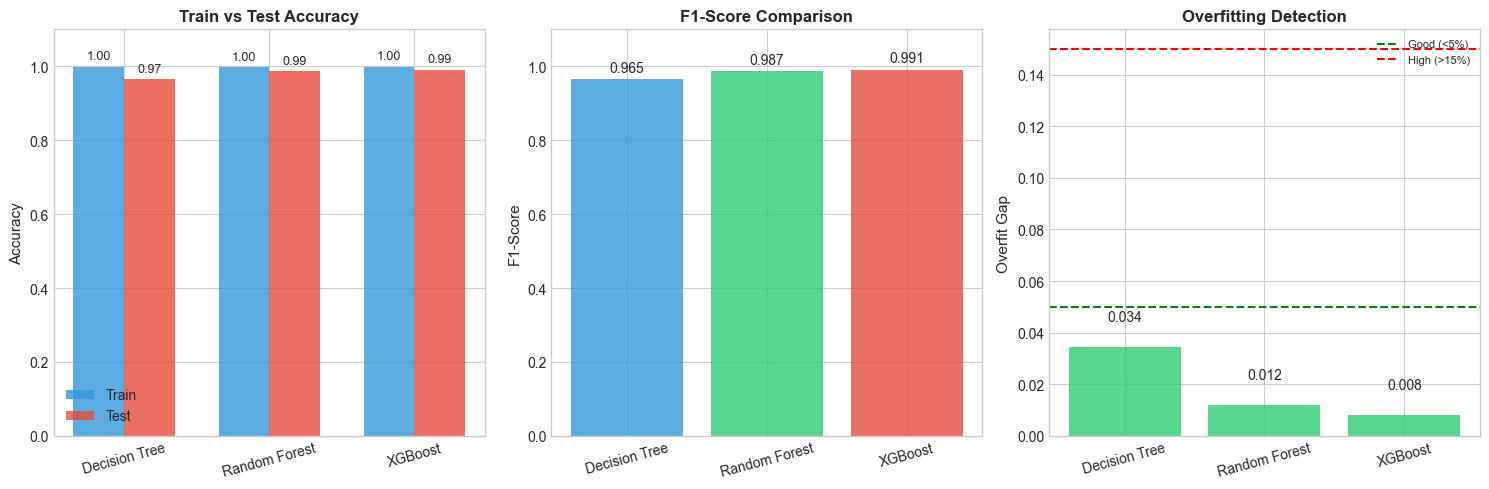

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = comparison_df.index.tolist()
x = np.arange(len(models))
width = 0.35
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Plot 1: Train vs Test Accuracy
axes[0].bar(x - width/2, comparison_df['Train_Accuracy'], width, label='Train', color='#3498db', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test_Accuracy'], width, label='Test', color='#e74c3c', alpha=0.8)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Train vs Test Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15)
axes[0].legend()
axes[0].set_ylim(0, 1.1)
for i, (train, test) in enumerate(zip(comparison_df['Train_Accuracy'], comparison_df['Test_Accuracy'])):
    axes[0].text(i - width/2, train + 0.02, f'{train:.2f}', ha='center', fontsize=9)
    axes[0].text(i + width/2, test + 0.02, f'{test:.2f}', ha='center', fontsize=9)

# Plot 2: F1-Score
bars = axes[1].bar(models, comparison_df['F1_Score'], color=colors[:len(models)], alpha=0.8)
axes[1].set_ylabel('F1-Score', fontsize=11)
axes[1].set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(models, rotation=15)
axes[1].set_ylim(0, 1.1)
for bar, val in zip(bars, comparison_df['F1_Score']):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', ha='center', fontsize=10)

# Plot 3: Overfit Gap
gap_colors = ['#2ecc71' if g < 0.05 else '#f39c12' if g < 0.15 else '#e74c3c' for g in comparison_df['Overfit_Gap']]
bars = axes[2].bar(models, comparison_df['Overfit_Gap'], color=gap_colors, alpha=0.8)
axes[2].axhline(y=0.05, color='green', linestyle='--', label='Good (<5%)')
axes[2].axhline(y=0.15, color='red', linestyle='--', label='High (>15%)')
axes[2].set_ylabel('Overfit Gap', fontsize=11)
axes[2].set_title('Overfitting Detection', fontsize=12, fontweight='bold')
axes[2].set_xticklabels(models, rotation=15)
axes[2].legend(loc='upper right', fontsize=8)
for bar, val in zip(bars, comparison_df['Overfit_Gap']):
    axes[2].text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('data/final/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 💾 Export Models for Dashboard Integration
---

## 22. Save All Models

In [22]:
# Create models directory
os.makedirs('models', exist_ok=True)

# Select best model
best_model_name = comparison_df['Test_Accuracy'].idxmax()
if best_model_name == 'Decision Tree':
    best_model = dt_best
elif best_model_name == 'Random Forest':
    best_model = rf_best
else:
    best_model = xgb_best

# Save models using joblib
print("💾 Saving models...")
print("="*50)

# Save best model
joblib.dump(best_model, 'models/best_model.joblib')
print(f"✅ Best model ({best_model_name}) saved: models/best_model.joblib")

# Save individual models
joblib.dump(dt_best, 'models/decision_tree_model.joblib')
print("✅ Decision Tree saved: models/decision_tree_model.joblib")

joblib.dump(rf_best, 'models/random_forest_model.joblib')
print("✅ Random Forest saved: models/random_forest_model.joblib")

if XGBOOST_AVAILABLE:
    joblib.dump(xgb_best, 'models/xgboost_model.joblib')
    print("✅ XGBoost saved: models/xgboost_model.joblib")

# Save scaler
joblib.dump(scaler, 'models/scaler.joblib')
print("✅ Scaler saved: models/scaler.joblib")

# Save label encoder
joblib.dump(label_encoder, 'models/label_encoder.joblib')
print("✅ Label encoder saved: models/label_encoder.joblib")

# Save feature columns
with open('models/feature_columns.txt', 'w') as f:
    f.write('\n'.join(feature_cols))
print("✅ Feature columns saved: models/feature_columns.txt")

💾 Saving models...
✅ Best model (XGBoost) saved: models/best_model.joblib
✅ Decision Tree saved: models/decision_tree_model.joblib
✅ Random Forest saved: models/random_forest_model.joblib
✅ XGBoost saved: models/xgboost_model.joblib
✅ Scaler saved: models/scaler.joblib
✅ Label encoder saved: models/label_encoder.joblib
✅ Feature columns saved: models/feature_columns.txt


## 23. Save Model Metadata

In [23]:
# Create comprehensive model info
model_info = {
    'best_model_name': best_model_name,
    'train_accuracy': float(comparison_df.loc[best_model_name, 'Train_Accuracy']),
    'test_accuracy': float(comparison_df.loc[best_model_name, 'Test_Accuracy']),
    'precision': float(comparison_df.loc[best_model_name, 'Precision']),
    'recall': float(comparison_df.loc[best_model_name, 'Recall']),
    'f1_score': float(comparison_df.loc[best_model_name, 'F1_Score']),
    'overfit_gap': float(comparison_df.loc[best_model_name, 'Overfit_Gap']),
    'feature_columns': feature_cols,
    'class_names': list(class_names),
    'n_classes': n_classes,
    'n_features': len(feature_cols),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'trained_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'all_model_metrics': comparison_df.to_dict()
}

# Save as pickle
with open('models/model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("✅ Model metadata saved: models/model_info.pkl")

# Also save as JSON for readability
import json
model_info_json = model_info.copy()
model_info_json['all_model_metrics'] = comparison_df.round(4).to_dict()
with open('models/model_info.json', 'w') as f:
    json.dump(model_info_json, f, indent=2)
print("✅ Model metadata saved: models/model_info.json")

✅ Model metadata saved: models/model_info.pkl
✅ Model metadata saved: models/model_info.json


## 24. Test Model Loading & Prediction

In [24]:
print("🔄 Testing model loading and prediction...")
print("="*50)

# Load saved model
loaded_model = joblib.load('models/best_model.joblib')
loaded_scaler = joblib.load('models/scaler.joblib')
loaded_encoder = joblib.load('models/label_encoder.joblib')

# Test with sample data
sample_indices = np.random.choice(len(X_test), size=10, replace=False)
sample_X = X_test[sample_indices]
sample_y_true = y_test[sample_indices]

# Make predictions
sample_scaled = loaded_scaler.transform(sample_X)
sample_pred = loaded_model.predict(sample_scaled)

# Convert to labels
pred_labels = loaded_encoder.inverse_transform(sample_pred)
true_labels = loaded_encoder.inverse_transform(sample_y_true)

print("\n📊 Sample Predictions:")
print("-"*50)
correct = 0
for i, (true, pred) in enumerate(zip(true_labels, pred_labels)):
    status = "✅" if true == pred else "❌"
    if true == pred:
        correct += 1
    print(f"   {i+1}. Actual: {true:15} | Predicted: {pred:15} {status}")

print(f"\n   Sample Accuracy: {correct}/10 ({correct*10}%)")

🔄 Testing model loading and prediction...

📊 Sample Predictions:
--------------------------------------------------
   1. Actual: Agricultural    | Predicted: Agricultural    ✅
   2. Actual: Vehicular       | Predicted: Vehicular       ✅
   3. Actual: Industrial      | Predicted: Industrial      ✅
   4. Actual: Natural         | Predicted: Natural         ✅
   5. Actual: Vehicular       | Predicted: Vehicular       ✅
   6. Actual: Industrial      | Predicted: Industrial      ✅
   7. Actual: Industrial      | Predicted: Industrial      ✅
   8. Actual: Agricultural    | Predicted: Agricultural    ✅
   9. Actual: Agricultural    | Predicted: Agricultural    ✅
   10. Actual: Industrial      | Predicted: Industrial      ✅

   Sample Accuracy: 10/10 (100%)


## 25. Final Summary

In [25]:
print("\n" + "="*70)
print("🎉 MODEL TRAINING COMPLETE!")
print("="*70)

print(f"\n📊 DATASET SUMMARY:")
print(f"   Total Records: {len(df):,}")
print(f"   Training Set: {len(X_train):,} samples (80%)")
print(f"   Test Set: {len(X_test):,} samples (20%)")
print(f"   Features Used: {len(feature_cols)}")
print(f"   Classes: {n_classes} ({', '.join(class_names)})")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Train Accuracy: {model_info['train_accuracy']:.4f} ({model_info['train_accuracy']*100:.2f}%)")
print(f"   Test Accuracy:  {model_info['test_accuracy']:.4f} ({model_info['test_accuracy']*100:.2f}%)")
print(f"   Precision:      {model_info['precision']:.4f}")
print(f"   Recall:         {model_info['recall']:.4f}")
print(f"   F1-Score:       {model_info['f1_score']:.4f}")
print(f"   Overfit Gap:    {model_info['overfit_gap']:.4f}")

# Overfitting status
if model_info['overfit_gap'] < 0.05:
    print(f"\n   ✅ Model has GOOD generalization (gap < 5%)")
elif model_info['overfit_gap'] < 0.15:
    print(f"\n   ⚠️ Model has MODERATE overfitting (gap < 15%)")
else:
    print(f"\n   ❌ Model has HIGH overfitting (gap > 15%)")

print(f"\n📁 SAVED FILES:")
for f in sorted(os.listdir('models')):
    size = os.path.getsize(f'models/{f}') / 1024
    print(f"   models/{f} ({size:.1f} KB)")

print(f"\n📊 VISUALIZATIONS:")
for f in os.listdir('data/final'):
    if f.endswith('.png'):
        print(f"   data/final/{f}")

print("\n" + "="*70)
print("✅ Models ready for dashboard integration!")
print("="*70)


🎉 MODEL TRAINING COMPLETE!

📊 DATASET SUMMARY:
   Total Records: 46,319
   Training Set: 37,055 samples (80%)
   Test Set: 9,264 samples (20%)
   Features Used: 9
   Classes: 5 (Agricultural, Burning, Industrial, Natural, Vehicular)

🏆 BEST MODEL: XGBoost
   Train Accuracy: 0.9996 (99.96%)
   Test Accuracy:  0.9915 (99.15%)
   Precision:      0.9915
   Recall:         0.9915
   F1-Score:       0.9915
   Overfit Gap:    0.0081

   ✅ Model has GOOD generalization (gap < 5%)

📁 SAVED FILES:
   models/best_model.joblib (2066.6 KB)
   models/best_model.pkl (1618.2 KB)
   models/decision_tree_model.joblib (221.2 KB)
   models/feature_columns.txt (0.1 KB)
   models/label_encoder.joblib (0.6 KB)
   models/model_info.json (1.4 KB)
   models/model_info.pkl (0.8 KB)
   models/random_forest_model.joblib (36105.2 KB)
   models/scaler.joblib (0.8 KB)
   models/xgboost_model.joblib (2066.6 KB)

📊 VISUALIZATIONS:
   data/final/cm_decision_tree.png
   data/final/cm_random_forest.png
   data/final/cm_x